In [24]:
import os
import keyring
import json
import operator

from typing import Annotated, Literal, List, Optional, TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import create_react_agent

from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool

# Setup for tools
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_mac')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_mac')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Set up LangSmith observability
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = keyring.get_password('langsmith', 'learning_agent')
os.environ['LANGCHAIN_PROJECT'] = "pr-stupendous-hood-8"

In [25]:
# tavily search tool
search_tool = TavilySearchResults(max_results=5)

# Set web search and scraping tools
@tool
def scrape_webpages(urls: List[str]) -> str:
    """ Use requests and bs4 ro scrape the provideed web pages for detailed information. """
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f"\n{doc.page_content}\n"
            for doc in docs
        ]
    )
    
# Define the tools
tools = [
    search_tool,
    scrape_webpages
]

In [26]:
# Define sub-agents and supervisor agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    # extracted_contentions = result.get("contentions", [])
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)], 
    }

In [27]:
# Make a query analysis team
import functools
import operator

# QueryAnalysisTeam graph state
class QueryAnalysisTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of the other's skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function that will update this every time it makes a decision
    next: str
    # Supervisor's instruction to the agent
    instruction: str
    # The list of contention extracted from the query
    contentions: Annotated[List[str], operator.add]

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [28]:
# Query Agent : John
query_system = """
You are a text analysis specialist in a Query Analysis Team.
Your primary role is to extract contentious issues from the input text that require fact-checking.

Your Responsibilities:
	1.	Analyze the input text carefully to identify potential areas of controversy or claims requiring verification.
	2.	Extract specific contentious issues, including any claims, statistics, or opinions that might spark debate or require validation.

Output Format:
- Provide the output in the following structure:
[Briefly describe the first contentious issue or claim]
[Briefly describe the second contentious issue or claim]
...
"""

query_agent = create_react_agent(llm, tools=[], state_modifier=query_system)
query_node = functools.partial(agent_node, agent=query_agent, name="John")

In [29]:
# Summary agent : Alicia
summary_system = """ 
You are a text summarization specialist in a Query Analysis Team.
Your primary responsibility is to summarize contentious issues that have been extracted by a query analyst. Your goal is to ensure the summaries are clear, concise, and prepared for efficient fact-checking.

Responsibilities:
	1.	Review Extracted Contentious Issues:
Carefully analyze the issues provided by the query analyst, ensuring you fully understand the context and significance of each issue.
	2.	Summarize Issues Clearly and Concisely:
Create concise summaries that capture the essence of each contentious issue while ensuring clarity and relevance for fact-checking purposes.
	3.	Organize Summaries in a Structured Format:
Present the summarized issues in a clean and structured format that is easy to reference and understand.

Output Format:
{
    "summarized_contentious_issues": [
        "Summarized issue 1",
        "Summarized issue 2",
        "Summarized issue 3"
    ]
}
…
"""
def summary_agent_node(state, agent, name):
    result = agent.invoke(state)
    try:
        output = json.loads(result["messages"][-1].content)
        summarized_issues = output.get("summarized_contentious_issues", [])
        if not summarized_issues:
            raise ValueError("Summarized contentions are empty.")
    except (json.JSONDecodeError, KeyError, ValueError) as e:
        summarized_issues = ["Error in summarizing contentions: " + str(e)]
    
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)],
        "contentions": summarized_issues,
    }

summary_agent = create_react_agent(llm, tools=[], state_modifier=summary_system)
summary_node = functools.partial(summary_agent_node, agent=summary_agent, name="Alicia")

In [40]:
### Supervisor agent
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-Based router"""
    options = ["FINISH"] + members
    
    # Define a function for OpenAI function calling : https://platform.openai.com/docs/guides/function-calling
    route_tool = {
        "name": "route",
        "description": "Select the next role and optionally provide clear instructions for the selected role to carry out",
        "parameters": {
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "type": "string",
                    "enum": options,
                    "description": "The next team member to act or FINISH if the process is complete."
                },
                "instructions": {
                    "title": "Instruction",
                    "type": "string",
                    "description": "Optional: Provide a clear instruction for the selected team member."
                }
            },
            "required": ["next"]  # 'instructions' is not required
        }
    }
    
    # Create the prompt template
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                """Given the conversation above, who should act next?
                OR should we FINISH?, select one of : {options}.
                Optionally, provide instructions for the selected team member.
                """
            )
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[route_tool], function_call="route")
        | JsonOutputFunctionsParser()
    )



supervisor_agent = create_team_supervisor(
    llm,
    """Your team is responsible for identifying and summarizing contentious issues from the given text to prepare for fact-checking by a fact-finding team.
    As the supervisor, you are tasked with managing a conversation between the following workers: John and Alicia.

    Responsibilities:
        1.	Manage Task Assignment:
        •	Evaluate the user input and decide which worker, John or Alicia, should act next based on their expertise.
        •	If a worker’s output requires additional refinement or improvements, assign them further tasks.
        2.	Evaluate Outputs:
        •	Review the results provided by each worker.
        •	If the output is satisfactory, assign the next worker or conclude the process.
        3.	Complete the Process:
        •	Once all contentious issues have been identified and summarized, respond with “FINISH” to conclude the task.

    Guidelines:
        •	Assign tasks efficiently to ensure the process moves forward productively.
        •	Provide constructive feedback to workers if their outputs need improvement.
        •	Ensure that the final output is clear, concise, and actionable for the fact-finding team.
    ### Output Instructions:
    Respond with a valid JSON object formatted as follows:
    "next": "QueryAnalysis",  // Replace "QueryAnalysis" with "Summarize" or "FINISH" as appropriate.
    "instructions": "You need get more contentions. Check the numbers."
    """,
    ["QueryAnalysis", "Summarize"],
)

In [41]:
# Build a Query Team graph define chain for super layer
query_workflow = StateGraph(QueryAnalysisTeamState)
query_workflow.add_node("John", query_node)
query_workflow.add_node('Supervisor', supervisor_agent)
query_workflow.add_node('Alicia', summary_node)
query_workflow.add_edge("John", "Supervisor")
query_workflow.add_edge("Alicia", "Supervisor")
query_workflow.add_edge(START, "Supervisor")
query_workflow.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {
        "QueryAnalysis": "John", 
        "Summarize": "Alicia",
        "FINISH": END
    }
)
query_graph = query_workflow .compile()

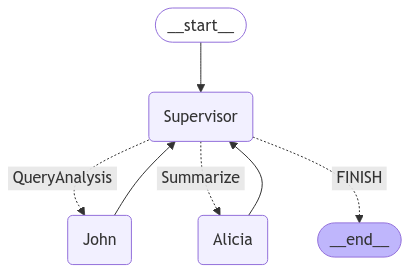

In [42]:
from IPython.display import Image, display
display(Image(query_graph.get_graph().draw_mermaid_png()))

In [43]:
for s in query_graph.stream(
    {
        "messages": [HumanMessage(
            content="Recent studies suggest that over 70% of people globally support the use of artificial intelligence in law enforcement. However, critics argue that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias. Additionally, some governments claim that implementing AI surveillance has reduced crime rates by as much as 40%, but human rights organizations dispute these figures, stating that the data lacks transparency and reliability."
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'QueryAnalysis'}}
---
{'John': {'messages': [HumanMessage(content='Recent studies suggest that over 70% of people globally support the use of artificial intelligence in law enforcement. [This claim about global support for AI in law enforcement requires verification regarding the methodology and sample size of the studies cited.]\n\nCritics argue that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias. [This assertion about the increase in wrongful arrests due to AI needs fact-checking to confirm the accuracy of the statistic and the context in which it was derived.]\n\nSome governments claim that implementing AI surveillance has reduced crime rates by as much as 40%. [This claim about crime rate reduction due to AI surveillance requires validation, particularly regarding the sources of the data and the criteria used to measure crime rates.]\n\nHuman rights organizations dispute these figures, stating that the data l

In [44]:
for s in query_graph.stream(
    {
        "messages": [HumanMessage(
            content="2024년 한국 GDP가 1000억 달러를 돌파했다."
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'QueryAnalysis'}}
---
{'John': {'messages': [HumanMessage(content='2024년 한국 GDP가 1000억 달러를 돌파했다는 주장은 사실 확인이 필요하다. 현재 시점에서 2024년의 GDP 수치는 예측에 불과하며, 실제 수치가 이와 일치하는지 검증이 필요하다.', additional_kwargs={}, response_metadata={}, name='John')]}}
---
{'Supervisor': {'next': 'QueryAnalysis'}}
---
{'John': {'messages': [HumanMessage(content='2024년 한국 GDP가 1000억 달러를 돌파했다는 주장은 사실 확인이 필요하다. 현재 시점에서 2024년의 GDP 수치는 예측에 불과하며, 실제 수치가 이와 일치하는지 검증이 필요하다.', additional_kwargs={}, response_metadata={}, name='John')]}}
---
{'Supervisor': {'next': 'QueryAnalysis'}}
---
{'John': {'messages': [HumanMessage(content='2024년 한국 GDP가 1000억 달러를 돌파했다는 주장에 대한 사실 확인이 필요하다. 현재 시점에서 2024년의 GDP 수치는 예측에 불과하므로, 실제 수치와의 일치 여부를 검증해야 한다.', additional_kwargs={}, response_metadata={}, name='John')]}}
---
{'Supervisor': {'next': 'QueryAnalysis'}}
---
{'John': {'messages': [HumanMessage(content='2024년 한국 GDP가 1000억 달러를 돌파했다는 주장은 예측에 기반하고 있으며, 실제 수치와의 일치 여부를 확인해야 한다.', additional_kwargs={}, response_metadata={}, 